In [131]:
from data_rnn import load_ndfa
import matplotlib.pyplot as plt
import numpy as np
import random
from time import time

In [132]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
import torch.distributions as dist

In [133]:
# NDFA
x_train, (i2w, w2i) = load_ndfa(n=150_000)

# # Brackets
# x_train, (i2w, w2i) = load_brackets(n=150_000)

In [134]:
print(''.join([i2w[i] for i in  x_train[10_000]]) )

ss


In [135]:
vocab_size = len(w2i)
vocab_size

15

In [136]:
w2i

{'.pad': 0,
 '.start': 1,
 '.end': 2,
 '.unk': 3,
 'u': 4,
 '!': 5,
 'k': 6,
 'm': 7,
 'c': 8,
 'a': 9,
 'b': 10,
 'w': 11,
 'l': 12,
 's': 13,
 'v': 14}

In [137]:
def get_max_seq_length(batch):
    return max(len(seq) for seq in batch)

In [138]:
def get_sum_seq_lengths(batch):
    return sum(len(seq) for seq in batch)

In [139]:
def add_padding(seq, amt=1):
    for _ in range(amt):
        seq.append(w2i['.pad'])
    return seq

In [140]:
def add_start(seq):
    seq.insert(0, w2i['.start'])
    return seq

In [141]:
def add_end(seq):
    seq.append(w2i['.end'])
    return seq

In [142]:
get_max_seq_length(x_train)

158

In [143]:
get_sum_seq_lengths(x_train) / len(x_train)

13.96264

In [144]:
def preprocess_batch(batch):
    max_len = get_max_seq_length(batch)
    
    upd_batch = []
    for i, _ in enumerate(batch):
        seq = batch[i].copy()
        seq = add_start(seq)
        seq = add_end(seq)
        seq = add_padding(seq, amt=max_len + 2 - len(seq))
        upd_batch.append(seq)
    
    upd_batch = torch.tensor(upd_batch, dtype=torch.long)
    return upd_batch

In [145]:
def get_batches(data, vocab_size, token_amt=60000):
    batches = []
    targets = []

    bound_l, bound_r = -1, 0
    idx = 0
    
    while bound_r < len(data):
        bound_l = bound_r

        num_of_tokens = 0
        while (num_of_tokens + len(data[idx])) < token_amt and bound_r < len(data):
            num_of_tokens += len(data[idx])
            bound_r += 1
        print(bound_l, bound_r)
        batch = data[bound_l:bound_r]
        batch = preprocess_batch(batch)
        target = F.pad(batch, (0, 1), "constant", 0)[:, 1:]
        # target = F.one_hot(target, num_classes=vocab_size)

        batches.append(batch)
        targets.append(target)
    return batches, targets

In [146]:
batches, targets = get_batches(x_train, vocab_size)

0 29999
29999 59998
59998 89997
89997 119996
119996 149995
149995 150000


In [147]:
len(batches)

6

In [148]:
batches[0][:10]

tensor([[ 1, 13, 13,  2],
        [ 1, 13, 13,  2],
        [ 1, 13, 13,  2],
        [ 1, 13, 13,  2],
        [ 1, 13, 13,  2],
        [ 1, 13, 13,  2],
        [ 1, 13, 13,  2],
        [ 1, 13, 13,  2],
        [ 1, 13, 13,  2],
        [ 1, 13, 13,  2]])

### Question 5

In [149]:
class Net(nn.Module):
    def __init__(self,
                 vocab_size,
                 embedding_size=32,
                 hidden_size=16,
                 lstm_num_layers=3) -> None:
        super().__init__()

        self.embed = nn.Embedding(vocab_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size, lstm_num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        input = self.embed(x)
        lstm_output, (hn, cn) = self.lstm(input)
        output = self.linear(lstm_output)
        return output

In [150]:
vocab_size=len(w2i)
embedding_size = 32
hidden_size = 16
lstm_num_layers = 1

epochs = 3
learning_rate = 0.01

In [151]:
if torch.cuda.is_available():
    device = torch.device('cuda') 
else:
    device = torch.device('cpu') 

device

device(type='cpu')

In [152]:
net = Net(vocab_size, embedding_size, hidden_size, lstm_num_layers)

In [153]:
net

Net(
  (embed): Embedding(15, 32)
  (lstm): LSTM(32, 16, batch_first=True)
  (linear): Linear(in_features=16, out_features=15, bias=True)
)

In [154]:
def batch_generator(batches, targets):
    indices = list(range(len(batches)))
    random.shuffle(indices)
    # print(f'Shuffle: {indices}')
    
    for ind in indices:
        yield batches[ind], targets[ind]

In [155]:
outputs = net(batches[0])
outputs.shape

torch.Size([29999, 4, 15])

In [156]:
batches[0][:10]

tensor([[ 1, 13, 13,  2],
        [ 1, 13, 13,  2],
        [ 1, 13, 13,  2],
        [ 1, 13, 13,  2],
        [ 1, 13, 13,  2],
        [ 1, 13, 13,  2],
        [ 1, 13, 13,  2],
        [ 1, 13, 13,  2],
        [ 1, 13, 13,  2],
        [ 1, 13, 13,  2]])

In [157]:
def train(model, batches, targets, epochs=3, learning_rate=0.01, device=torch.device('cpu')):
    # Loss function:
    # check whether the loss function applies softmax or whether we need to do it manually
    # loss function = cross entropy loss at every point in time, read doc to figure out
    # how to shuffle dimensions properly

    # criterion = nn.CrossEntropyLoss(reduction='sum') # 'sum': the output will be summed, since we want loss on every step
    
    model.to(device)
    criterion = nn.CrossEntropyLoss(reduction='sum', ignore_index=w2i['.pad'])
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    metrics = {
        'loss_history_per_token': [],
        'loss_history': [],
        'loss_train': []
    }

    # Training loop
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}\n-------------------------------")
        total_loss = 0.0

        n_batches = -1

        model.train()
        for i, (X, y) in enumerate(batch_generator(batches, targets)):
            X, y = X.to(device), y.to(device)
            # print(X[:1], y[:1])

            # zero the parameter gradients
            optimizer.zero_grad()

            # Compute prediction error
            start_time = time()
            outputs = model(X)
            # outputs = outputs.softmax(dim=-1)
            # loss = criterion(outputs, y.type(torch.float64))
            
            loss = criterion(outputs.reshape(outputs.shape[0]*outputs.shape[1], -1), y.reshape(y.shape[0]*y.shape[1], )) # outputs: [batch_size*time, vocab_size], y:[batch_size*time]

            # Backpropagation
            loss.backward()
            optimizer.step()

            finish_time = time()

            # print statistics
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {loss.item() / y.size()[0] / y.size()[-1]:.6f} time: {finish_time - start_time:.3f}')
            metrics['loss_history_per_token'].append(loss.item() / y.size()[0] / y.size()[-1]) # loss per token for each iteration
            metrics['loss_history'].append(loss.item())
            n_batches = i

        metrics['loss_train'].append(total_loss/(n_batches + 1)) # mean loss per epoch

    return model, metrics

In [158]:
model = Net(vocab_size, embedding_size, hidden_size, lstm_num_layers)
model, metrics = train(model, batches, targets, epochs, learning_rate, device)

Epoch 1
-------------------------------
tensor([[ 1, 13,  4, 14, 11,  5,  4, 14, 11,  5,  4, 14, 11,  5, 13,  2,  0,  0,
          0,  0,  0,  0,  0,  0]]) tensor([[13,  4, 14, 11,  5,  4, 14, 11,  5,  4, 14, 11,  5, 13,  2,  0,  0,  0,
          0,  0,  0,  0,  0,  0]])
[1,     1] loss: 2.037721 time: 2.368
tensor([[ 1, 13, 13,  2]]) tensor([[13, 13,  2,  0]])
[1,     2] loss: 2.081032 time: 0.298
tensor([[ 1, 13, 13,  2,  0,  0,  0,  0]]) tensor([[13, 13,  2,  0,  0,  0,  0,  0]])
[1,     3] loss: 2.037353 time: 0.575
tensor([[ 1, 13,  6, 12,  7,  5, 13,  2,  0,  0,  0,  0,  0,  0,  0,  0]]) tensor([[13,  6, 12,  7,  5, 13,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0]])
[1,     4] loss: 1.806776 time: 1.442
tensor([[ 1, 13,  9, 10,  8,  5,  9, 10,  8,  5,  9, 10,  8,  5,  9, 10,  8,  5,
          9, 10,  8,  5,  9, 10,  8,  5,  9, 10,  8,  5,  9, 10,  8,  5,  9, 10,
          8,  5,  9, 10,  8,  5,  9, 10,  8,  5,  9, 10,  8,  5,  9, 10,  8,  5,
          9, 10,  8,  5,  9, 10,  8,  5,  9

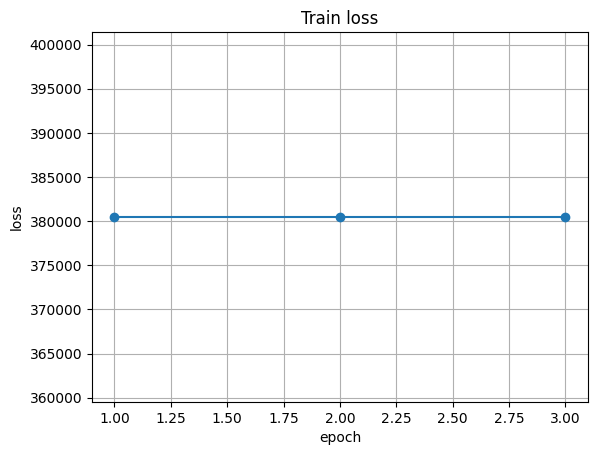

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(1, epochs + 1), metrics['loss_train'], marker='o')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Train loss')
plt.grid()
plt.show()

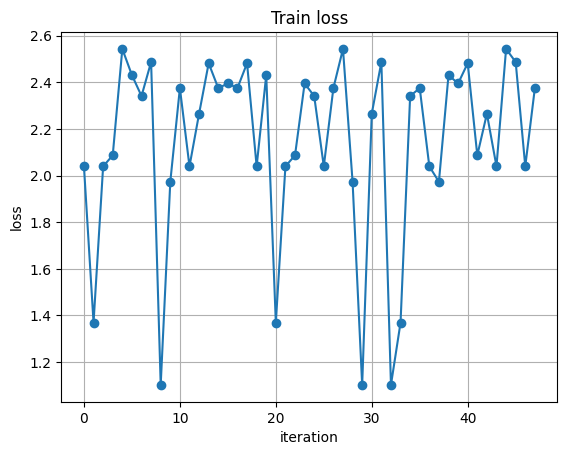

In [ ]:
plt.plot(metrics['loss_history_per_token'], marker='o')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('Train loss')
plt.grid()
plt.show()

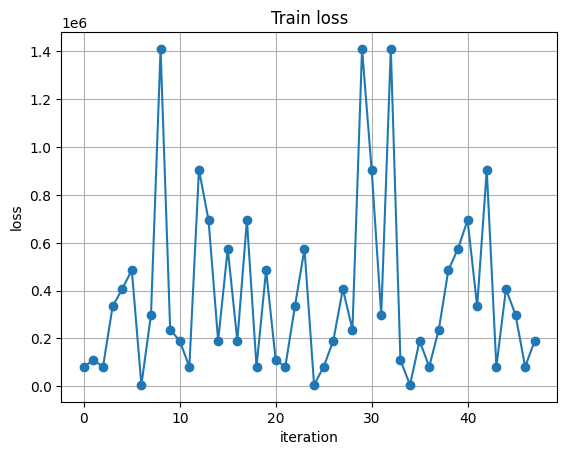

In [ ]:
plt.plot(metrics['loss_history'], marker='o')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('Train loss')
plt.grid()
plt.show()

In [ ]:
# def predict(dataset, model, seq, temperature=1.0, max_length=20):
#     """
#     :param dataset: need i2w and w2i
#     :param model: the model we sample from
#     :param seq: the sequence of tokens we want to complete
#     :param max_length: we stop if we reach an end token, or after max_length tokens
#     :return: the generated sequence of tokens
#     """
#     model.eval()
#     pred = []
#     for i in range(0, max_length):
#         x = torch.tensor([[dataset.w2i[i] for w in seq[i:]]])
#         y = model.forward(x)
#         last_token_logits = y[0][-1]
#         j = sample(last_token_logits, temperature)
#         pred.append(seq.dataset.i2w[j])
#         if seq.dataset.i2w[j] == '.end':
#             return pred
#     return pred

In [ ]:
# print("Predicting:")
# model.eval()
# seq = ['.start', 'a', 'b']
# predict(model, dataset, seq, max_length=20

In [ ]:
# def evaluate(model):
#     """
#     In both cases, we will consider the learning successful if in a sample of 10 sequences, the
#     majority is correct. This is not very strict, but it will suffice for our purposes. To check if a long
#     string is correct for the bracket data, just check that it contains the same number of opening and closing brackets.
#     """
#     pass